In [14]:
import gensim
import numpy as np
import scipy
import scipy.spatial
import MeCab
import nltk
import xlrd
import string
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

mecab = MeCab.Tagger("-Owakati")

In [19]:
# Select all words in the data file and compute the vocabulary. 
# Write the cross-lingual word embeddings for those words to a separate file.
# This will speed up loading word embeddings and save memory.

data_files = ["../data/olddata.xlsx", "../data/newdata.xlsx"]
vocab = set()
for fname in data_files:
    trans_data = xlrd.open_workbook(fname)
    sheet = trans_data.sheet_by_index(0)  
    for l in range(1, sheet.nrows):
        # tokenise Japanese texts
        rows = sheet.row_values(l, 0, sheet.ncols)
        token_ja = mecab.parse(rows[0].lower())
        vocab = vocab.union(set(token_ja.strip().split()))    
        # tokenise English texts
        vocab = vocab.union(set(nltk.word_tokenize(rows[1].lower())))

stop_words = ['(', ')', '[', ']', '@', '•', '`', '-', '❚❚', '●', '（√',  '×', '。', '＠']
add_words = ['I', 'like', 'hate', 'cat', 'cats', 'dog', 'dogs', 'banana', '好き', '嫌い', '猫', '犬', '私']
vocab = vocab - set(stop_words)
vocab = vocab.union(set(add_words))
print("No of unique words in the vocabulary = %d" % len(vocab))

# write the vocabulary to a file for debugging purposes
with open("../data/vocab.txt", 'w') as vocab_file:
    for word in vocab:
        vocab_file.write("%s\n" % word)

# Lets select the cross-lingual word embeddings for those words in the vocabulary.
cross_in_embeds_fname = "../data/ja-en.txt"
cross_out_embeds_fname = "../data/ja-en.sel"
first_line = True

with open(cross_in_embeds_fname) as cross_in:
    with open(cross_out_embeds_fname, 'w') as cross_out:
        for line in cross_in:
            if first_line:
                dim = int(line.split()[1])
                cross_out.write("%d %d\n" % (len(vocab), dim))
                first_line = False
            elif line.split()[0].lower() in vocab:
                cross_out.write(line)
    


No of unique words in the vocabulary = 2155


In [38]:
# Load the cross-lingual word embeddings.
large_embeddings = gensim.models.KeyedVectors.load_word2vec_format('../data/ja-en.txt')
small_embeddings = gensim.models.KeyedVectors.load_word2vec_format('../data/ja-en.sel')

In [41]:
embeddings = large_embeddings

In [4]:
def clean_text(s):
    stop_words = ['(', ')', '[', ']', '@', '•', '`', '-', '❚❚', '●', '（√',  '×', '。', '＠']
    for ch in stop_words:
        s = s.replace(ch, ' ')
    return s

In [5]:
def wmd(source, target):
    distance = embeddings.wmdistance(source, target)
    return (distance, 0)

In [35]:
def mwmd(source, target):
    # remove words that are not in the vocabulary from source and target.
    source = list(filter(lambda x: x in embeddings, source))
    target = list(filter(lambda x: x in embeddings, target))
     
    #print(source)    
    #print(target)

    
    n = len(source)
    m = len(target)
    
    # compute distances between words
    C = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            first, second = embeddings[source[i]],  embeddings[target[j]]
            first_norm, second_norm = np.linalg.norm(first), np.linalg.norm(second)
            if first_norm > 0:
                first = first / first_norm
            if second_norm > 0:
                second = second / second_norm            
            C[i,j] = scipy.spatial.distance.euclidean(first, second)
    
    # Initialise variables
    x = np.zeros(n + n*m, dtype=float)
    T = x[n:].reshape(n,m)
    y = x[:n]
    
    c = np.zeros_like(x)
    c[:n] = 1.0
    
    # Inequality constraints
    b_ub = np.zeros(n*m, dtype=float)
    A_ub = np.zeros((n*m, n + n*m), dtype=float)    
    for p in range(n*m):
        for q in range(n + n*m):
            if p % n == q:
                A_ub[p, q % n] = -1.0
            if (p // n) + 2 * (p % n) + n == q:
                A_ub[p,q] = C[p % n, p // n]    
    #print(A_ub)
    
    # Equality constraints for Eq. 5 (Columns in T must be stochastic)
    CA_eq = np.zeros((n, n + n*m), dtype=float)
    Cb_eq = np.ones(n, dtype=float)
    for p in range(n):
        for q in range(n + m*p, n + m + m*p):
            CA_eq[p,q] = 1.0
            
    # Equality constraints for Eq. 4 (Rows in T must be stochastic)
    RA_eq = np.zeros((m, n + n*m), dtype=float)
    Rb_eq = np.ones(m, dtype=float)
    for p in range(m):
        for q in range(n, n + n*m):
            if p == (q - n) % m:
                RA_eq[p,q] = 1.0
    
    print(RA_eq)
    
    
    res = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, method='simplex')
    #res = scipy.optimize.linprog(c, A_ub, b_ub, method='simplex')
    status = {0 : "Optimization terminated successfully",
              1 : "Iteration limit reached",
              2 : "Problem appears to be infeasible",
              3 : "Problem appears to be unbounded",
              4 : "Serious numerical difficulties encountered"}
    if res.status > 0:
        print("\x1b[31m %s \x1b[0m" % status[res.status])
    
    if res.status == 2:
        # Infeasible problem. Drop equality constrains and try again.
        res = scipy.optimize.linprog(c, A_ub, b_ub, method='simplex') 
        distance_y = np.sum(res.x[:n])
        distance_TC = C.flatten().dot(res.x[n:])
        return (distance_y, 2)        
    
    if res.status == 0:        
        print("No of iterations to optimisation = %d" % res.nit)
        # objective is the sum of y_i.
        distance_y = np.sum(res.x[:n])
        #print("sum y = %f" % distance_y)
        distance_TC = C.flatten().dot(res.x[n:])
        #print("sum TC = %f" % distance_TC)
        return (distance_y, res.status)
    else:
        return (0, res.status) 
    
    
    

In [7]:
# We provide a simple UI for entering source (Japanese) and target (English) texts to compare.

def Comparison(Source_Ja, Target_En):
    source = list(set(mecab.parse(Source_Ja.lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(Target_En.lower().strip())))
    #distance = wmd(source, target)
    distance = mwmd(source, target)[0]
    print("Semantic distance = %f\n" % distance)

interact_manual(Comparison, Source_Ja='私は猫が好きです', Target_En="I like dog");

The installed widget Javascript is the wrong version.


Total number of instances = 30
No of iterations to optimisation = 271
No of iterations to optimisation = 430
No of iterations to optimisation = 327
No of iterations to optimisation = 801
No of iterations to optimisation = 226
No of iterations to optimisation = 287
No of iterations to optimisation = 342
No of iterations to optimisation = 353
No of iterations to optimisation = 429
No of iterations to optimisation = 408
No of iterations to optimisation = 583
No of iterations to optimisation = 337
No of iterations to optimisation = 458
No of iterations to optimisation = 510
No of iterations to optimisation = 437
No of iterations to optimisation = 467
No of iterations to optimisation = 375
No of iterations to optimisation = 292
No of iterations to optimisation = 425
No of iterations to optimisation = 368
No of iterations to optimisation = 466
No of iterations to optimisation = 372
No of iterations to optimisation = 563
No of iterations to optimisation = 314
No of iterations to optimisation 

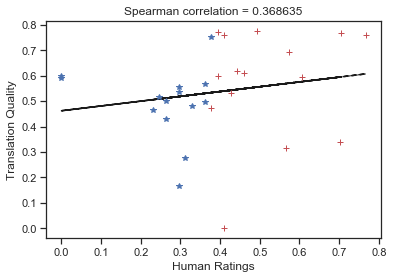

In [43]:
# We will compute the correlation between human ratings and semantic distances over all instances

trans_data = xlrd.open_workbook('../data/olddata.xlsx')  #open the Excel spreadsheet as workbook
sheet = trans_data.sheet_by_index(0)  
instances = []
for l in range(1, sheet.nrows):
    # tokenise Japanese texts
    rows = sheet.row_values(l, 0, sheet.ncols)
    instances.append((rows[0], rows[1], float(rows[2])))
print("Total number of instances = %d" % len(instances))

# 1000 random integers between 0 and 50

human_ratings = []
distances = []
bad_count = 0
for x in instances:
    source = list(set(mecab.parse(clean_text(x[0]).lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(clean_text(x[1]).lower().strip())))
    res = mwmd(source, target)
    if res[1] > 0:
        bad_count += 1
    else:
        distances.append(res[0])
        human_ratings.append(x[2])

print("Failed cases = %d" % bad_count)

# convert distances to similarity and scale to [0,1]
human_ratings = np.array(human_ratings)
human_ratings = 1.0 - (human_ratings / np.max(human_ratings))
distances = np.array(distances)
distances = 1.0 - (distances / np.max(distances))
spr = scipy.stats.spearmanr(human_ratings, distances)
print("Spearman Full", spr)

# Plot linear regression line
fit = np.polyfit(human_ratings, distances, 1)
fit_fn = np.poly1d(fit) 
plt.plot(human_ratings, fit_fn(human_ratings), '--k')

sortinds = np.argsort(human_ratings)
distances = distances[sortinds]
human_ratings = human_ratings[sortinds]
N = len(sortinds) // 2
low_human, high_human = human_ratings[: N], human_ratings[N:]
low_sim, high_sim = distances[:N], distances[N:]
print("Sperman Low", scipy.stats.spearmanr(low_human, low_sim))
print("Sperman High", scipy.stats.spearmanr(high_human, high_sim))

# Compute accuracy. For low_human, predicted value must be less than or equal, 
# and for high_human predicted value must be greater than or equal to be correct.

corrects = 0
for (x,y) in zip(low_human, low_sim):
    if fit_fn(x) >= y:
        corrects += 1
for (x,y) in zip(high_human, high_sim):
    if fit_fn(x) <= y:
        corrects += 1
print("Accuracy = ", float(100 * corrects) / float(len(distances)))
plt.plot(low_human, low_sim, 'b*', high_human, high_sim, 'r+')
plt.xlabel("Human Ratings")
plt.ylabel("Translation Quality")
plt.title("Spearman correlation = %f" % spr[0])
plt.show()


In [ ]:
# Process a dataset, predict similarities and save to a file.
trans_data = xlrd.open_workbook('../data/newdata.xlsx')  
sheet = trans_data.sheet_by_index(0)  
scores = []
for l in range(1, sheet.nrows):
    rows = sheet.row_values(l, 0, sheet.ncols)
    source = list(set(mecab.parse(clean_text(rows[0]).lower().strip('\n')).split()))
    target = list(set(nltk.word_tokenize(clean_text(rows[1]).lower().strip())))
    #res = mwmd(source, target)
    res = wmd(source, target)
    val = -1 if res[1] > 0 else res[0]
    scores.append(val)

scores = np.array(scores)
max_val = np.max(scores)
print("max val", max_val)
scores = 1.0 - (scores / max_val)
with open("../data/pred-sims.csv", "w") as out_file:
    for val in scores:
        print(val)
        out_file.write("%f\n" % val)
  
    


TODO:
- Check the performance of WMD and MWMD with the selected vocabulary covering old and new datasets and compare this against that with the full vocabulary.
- Use sum of y instead of TC in MWMD
- Implement double stochasticity in MWMD and check the performance and infeasibility
- Implement WMD also by yourself without resorting to gensim
- Add IDF weighting